In [475]:
from keras.datasets import mnist
from keras.layers import *
from keras.models import Model, Sequential
from keras.utils.vis_utils import plot_model
from keras.utils import np_utils
import keras
import keras.backend as K

import numpy as np

from sklearn.metrics import accuracy_score
import sklearn

import matplotlib.pyplot as plt
from IPython.display import Image
from tqdm import tqdm
from collections import deque
import seaborn as sns
import random,time

%matplotlib inline

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
num_actions = len(set(y_test))
image_w, image_h = X_train.shape[1:]

X_train = X_train.reshape(*X_train.shape,1)
X_test = X_test.reshape(*X_test.shape, 1)

#normalization
X_train = X_train/255.
X_test = X_test/255.

In [4]:
dummy_actions = np.ones((1, num_actions))

In [5]:
y_train_onehot = keras.utils.to_categorical(y_train, num_actions)

y_test_onehot = keras.utils.to_categorical(y_test, num_actions)

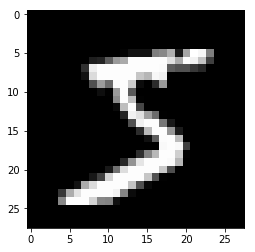

In [6]:
plt.imshow(X_train[0].reshape(28,28),'gray')

In [7]:
class MnEnviroment(object):
    def __init__(self, x,y):
        self.train_X = x
        self.train_Y = y
        self.current_index = self._sample_index()
        self.action_space = len(set(y)) - 1
    def reset(self):
        obs, _ = self.step(-1)
        return obs
    '''
    action: 0-9 categori, -1 : start and no reward
    return: next_state(image), reward
    '''
    def step(self, action):
        if action==-1:
            _c_index = self.current_index
            self.current_index = self._sample_index()
            return (self.train_X[_c_index], 0)
        r = self.reward(action)
        self.current_index = self._sample_index()
        return self.train_X[self.current_index], r
    
    def reward(self, action):
        c = self.train_Y[self.current_index]
        #print(c)
        return 1 if c==action else -1
        
    def sample_actions(self):
        return random.randint(0, self.action_space)
    
    def _sample_index(self):
        return random.randint(0, len(self.train_Y)-1)

In [8]:
env = MnEnviroment(X_train, y_train)

In [30]:
memory = deque(maxlen=512)
replay_size = 64
epoches = 2000
pre_train_num = 256
gamma = 0.  #every state is i.i.d
alpha = 0.5
forward = 512
epislon_total = 2018 

In [13]:
def createDQN(input_width, input_height, actions_num):
    img_input = Input(shape=(input_width, input_height,1),dtype='float32',name='image_inputs')
    #conv1
    conv1 = Conv2D(32,3,padding='same',activation='relu',kernel_initializer='he_normal')(img_input)
    conv2 = Conv2D(64,3,strides=2,padding='same', activation='relu',kernel_initializer='he_normal')(conv1)
    conv3 = Conv2D(64,3,strides=2,padding='same', activation='relu',kernel_initializer='he_normal')(conv2)
    conv4 = Conv2D(128,3,strides=2,padding='same', activation='relu',kernel_initializer='he_normal')(conv3)
    x = Flatten()(conv4)
    x = Dense(128, activation='relu')(x)
    outputs_q = Dense(actions_num, name='q_outputs')(x)
    #one hot input
    actions_input = Input((actions_num,),name='actions_input')
    q_value= multiply([actions_input, outputs_q])
    q_value = Lambda(lambda l:K.sum(l, axis=1,keepdims=True),name='q_value')(q_value)
    
    model = Model(inputs=[img_input, actions_input], outputs=q_value)
    model.compile(loss='mse',optimizer='adam')
    return model

In [14]:
actor_model = createDQN(image_w,image_h,num_actions) #用于决策
critic_model = createDQN(image_w,image_h,num_actions) #用于训练
actor_q_model = Model(inputs=actor_model.input, outputs=actor_model.get_layer('q_outputs').output)

In [15]:
def copy_critic_to_actor():
    critic_weights = critic_model.get_weights()
    actor_wegiths  = actor_model.get_weights()
    for i in range(len(critic_weights)):
        actor_wegiths[i] = critic_weights[i]
    actor_model.set_weights(actor_wegiths)

In [16]:
def get_q_values(model_,state):
    inputs_ = [state.reshape(1,*state.shape),dummy_actions]
    qvalues = model_.predict(inputs_)
    return qvalues[0]

In [103]:
def predict(model,states):
    inputs_ = [states, np.ones(shape=(len(states),num_actions))]
    qvalues = model.predict(inputs_)
    return np.argmax(qvalues,axis=1)

In [27]:
def epsilon_calc(step, ep_min=0.01,ep_max=1,ep_decay=0.0001,esp_total = 1000):
    return max(ep_min, ep_max -(ep_max - ep_min)*step/esp_total )

In [18]:
def epsilon_greedy(env, state, step, ep_min=0.01, ep_decay=0.0001,ep_total=1000):
    epsilon = epsilon_calc(step, ep_min, 1, ep_decay,ep_total)
    if np.random.rand()<epsilon:
        return env.sample_actions(),0
    qvalues = get_q_values(actor_q_model, state)
    return np.argmax(qvalues), np.max(qvalues)

In [19]:
def pre_remember(pre_go = 30):
    state = env.reset()
    for i in range(pre_go):
        rd_action = env.sample_actions()
        next_state, reward = env.step(rd_action)
        remember(state,rd_action,0,reward,next_state)
        state = next_state

In [20]:
def remember(state,action,action_q,reward,next_state):
    memory.append([state,action,action_q,reward,next_state])
    
def sample_ram(sample_num):
    return np.array(random.sample(memory,sample_num))

$$Q(s,a;\theta_{critic})=(1-\alpha)Q(s,a;\theta_{actor})+\alpha[R^{a}_{s}+\gamma \max_{a'}Q(s',a';\theta_{actor})] $$

In [24]:
def replay():
    if len(memory) < replay_size:
        return 
    #从记忆中i.i.d采样
    samples = sample_ram(replay_size)
    #展开所有样本的相关数据
    #这里next_states没用 因为和上一个state无关。
    states, actions, old_q, rewards, next_states = zip(*samples)
    states, actions, old_q, rewards = np.array(states),np.array(actions).reshape(-1,1),\
                                    np.array(old_q).reshape(-1,1),np.array(rewards).reshape(-1,1)
   
    actions_one_hot = np_utils.to_categorical(actions,num_actions)
    #print(states.shape,actions.shape,old_q.shape,rewards.shape,actions_one_hot.shape)
    #从actor获取下一个状态的q估计值 这里也没用 因为gamma=0 也就是不对bellman方程展开
    #inputs_ = [next_states,np.ones((replay_size,num_actions))]
    #qvalues = actor_q_model.predict(inputs_)
    
    #q = np.max(qvalues,axis=1,keepdims=True)
    q = 0
    q_estimate = (1-alpha)*old_q +  alpha *(rewards.reshape(-1,1) + gamma * q)
    history = critic_model.fit([states,actions_one_hot],q_estimate,epochs=1,verbose=0)
    return np.mean(history.history['loss'])

In [ ]:
"{:2f}".format(2.12)

In [53]:
memory.clear()
total_rewards = 0
reward_rec = []
pre_remember(pre_train_num)
every_copy_step = 128

In [54]:
epoches, forward, epislon_total,pre_train_num

(2000, 512, 2018, 256)

In [ ]:
pbar = tqdm(range(1,epoches+1))
state = env.reset()
for epoch in pbar:
    total_rewards = 0
    epo_start = time.time()
    for step in range(forward):
        #对每个状态使用epsilon_greedy选择
        action, q = epsilon_greedy(env, state, epoch, ep_min=0.01, ep_total=epislon_total)
        eps = epsilon_calc(epoch,esp_total=epislon_total)
        #play 
        next_state,reward = env.step(action)
        #加入到经验记忆中
        remember(state, action, q, reward, next_state)
        #从记忆中采样回放，保证iid。实际上这个任务中这一步不是必须的。
        loss = replay()
        total_rewards += reward
        state = next_state
        if step % every_copy_step==0:
            copy_critic_to_actor()
    reward_rec.append(total_rewards)
    pbar.set_description('R:{} L:{:.4f} T:{} P:{:.3f}'.format(total_rewards,loss,int(time.time()-epo_start),eps))





  0%|          | 0/2000 [00:00<?, ?it/s]





R:-428 L:0.0009 T:7 P:1.000:   0%|          | 0/2000 [00:07<?, ?it/s]


R:-428 L:0.0009 T:7 P:1.000:   0%|          | 1/2000 [00:07<4:23:58,  7.92s/it]


R:-392 L:0.0001 T:7 P:0.999:   0%|          | 1/2000 [00:15<8:41:28, 15.65s/it]


R:-392 L:0.0001 T:7 P:0.999:   0%|          | 2/2000 [00:15<4:20:39,  7.83s/it]


R:-398 L:0.0003 T:7 P:0.999:   0%|          | 2/2000 [00:22<6:19:02, 11.38s/it]


R:-398 L:0.0003 T:7 P:0.999:   0%|          | 3/2000 [00:22<4:12:35,  7.59s/it]


R:-392 L:0.0001 T:7 P:0.998:   0%|          | 3/2000 [00:30<5:40:06, 10.22s/it]


R:-392 L:0.0001 T:7 P:0.998:   0%|          | 4/2000 [00:30<4:14:59,  7.66s/it]


R:-410 L:0.0003 T:6 P:0.998:   0%|          | 4/2000 [00:37<5:12:16,  9.39s/it]


R:-410 L:0.0003 T:6 P:0.998:   0%|          | 5/2000 [00:37<4:09:43,  7.51s/it]


R:-400 L:0.0001 T:7 P:0.997:   0%|          | 5/2000 [00:44<4:56:27,  8.92s/it]


R:-400 L:0.0001 T:7 P:0.997:   0%|          | 6/2000 [00:4

R:-334 L:0.0163 T:7 P:0.956:   4%|▍         | 89/2000 [10:57<3:55:07,  7.38s/it]


R:-368 L:0.0007 T:6 P:0.956:   4%|▍         | 89/2000 [11:03<3:57:37,  7.46s/it]


R:-368 L:0.0007 T:6 P:0.956:   4%|▍         | 90/2000 [11:03<3:54:51,  7.38s/it]


R:-374 L:0.0000 T:7 P:0.955:   4%|▍         | 90/2000 [11:11<3:57:27,  7.46s/it]


R:-374 L:0.0000 T:7 P:0.955:   5%|▍         | 91/2000 [11:11<3:54:43,  7.38s/it]


R:-400 L:0.0009 T:7 P:0.955:   5%|▍         | 91/2000 [11:19<3:57:25,  7.46s/it]


R:-400 L:0.0009 T:7 P:0.955:   5%|▍         | 92/2000 [11:19<3:54:43,  7.38s/it]


R:-364 L:0.0005 T:8 P:0.954:   5%|▍         | 92/2000 [11:27<3:57:31,  7.47s/it]


R:-364 L:0.0005 T:8 P:0.954:   5%|▍         | 93/2000 [11:27<3:54:51,  7.39s/it]


R:-360 L:0.0001 T:6 P:0.954:   5%|▍         | 93/2000 [11:34<3:57:14,  7.46s/it]


R:-360 L:0.0001 T:6 P:0.954:   5%|▍         | 94/2000 [11:34<3:54:35,  7.38s/it]


R:-372 L:0.0001 T:6 P:0.953:   5%|▍         | 94/2000 [11:41<3:56:54,  7.46s/it]


R:-3

In [466]:
critic_model.save('crtic_2000.HDF5')

In [87]:
r5 = np.mean([reward_rec[i:i+10] for i in range(0,len(reward_rec),10)],axis=1)

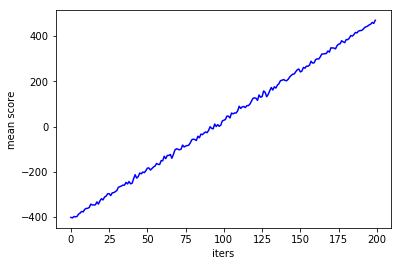

In [141]:
plt.plot(range(len(r5)),r5,c='b')
plt.xlabel('iters')
plt.ylabel('mean score')

In [ ]:
copy_critic_to_actor()

In [471]:
model_loaded = keras.models.load_model('crtic_2000.HDF5')

In [472]:
pred = predict(actor_q_model, X_test)

accuracy_score(y_test,pred)

0.97230000000000005

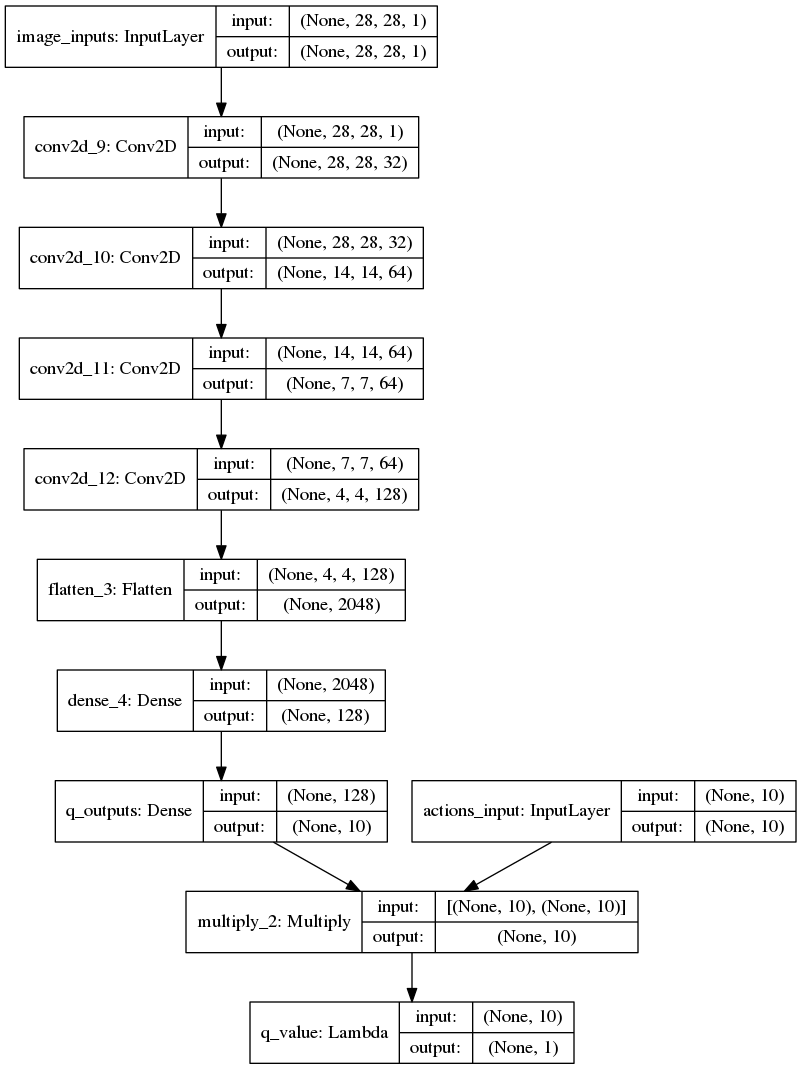

In [477]:
plot_model(model_loaded,'model.png',True)
Image('model.png')

In [160]:
X_train_og = X_train.reshape((-1,28,28))

In [161]:
X_test_og = X_test.reshape((-1,28,28))

In [170]:
rnn_model = Sequential()
rnn_model.add(GRU(64,input_shape=(28,28)))
rnn_model.add(Dense(32,activation='relu'))
rnn_model.add(Dense(num_actions, activation='softmax'))
rnn_model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [171]:
rnn_model.fit(X_train_og, y_train_onehot, batch_size=64, epochs=10, validation_split=0.1, verbose=1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 44s 811us/step - loss: 0.6815 - acc: 0.7715 - val_loss: 0.1811 - val_acc: 0.9483
Epoch 2/10
54000/54000 [==============================] - 43s 805us/step - loss: 0.1820 - acc: 0.9454 - val_loss: 0.1311 - val_acc: 0.9608
Epoch 3/10
54000/54000 [==============================] - 44s 812us/step - loss: 0.1216 - acc: 0.9625 - val_loss: 0.0839 - val_acc: 0.9750
Epoch 4/10
54000/54000 [==============================] - 43s 805us/step - loss: 0.0942 - acc: 0.9711 - val_loss: 0.0717 - val_acc: 0.9783
Epoch 5/10
54000/54000 [==============================] - 43s 797us/step - loss: 0.0765 - acc: 0.9769 - val_loss: 0.0768 - val_acc: 0.9770
Epoch 6/10
54000/54000 [==============================] - 43s 803us/step - loss: 0.0647 - acc: 0.9807 - val_loss: 0.0593 - val_acc: 0.9830
Epoch 7/10
54000/54000 [==============================] - 44s 810us/step - loss: 0.0586 - acc: 0.9823 - val_loss: 0.0

In [140]:
rnn_model.evaluate(X_test_og, y_test_onehot)

10000/10000 [==============================] - 4s 406us/step


[0.050150478051835673, 0.98509999999999998]

In [172]:
layer_dict = dict([(layer.name, layer) for layer in actor_model.layers])

In [173]:
layer_dict

{'actions_input': <keras.engine.topology.InputLayer at 0x7fdd90385898>,
 'conv2d_5': <keras.layers.convolutional.Conv2D at 0x7fdd904c2f98>,
 'conv2d_6': <keras.layers.convolutional.Conv2D at 0x7fdd904c2a20>,
 'conv2d_7': <keras.layers.convolutional.Conv2D at 0x7fdd904a9ef0>,
 'conv2d_8': <keras.layers.convolutional.Conv2D at 0x7fdd904320b8>,
 'dense_3': <keras.layers.core.Dense at 0x7fdd90401198>,
 'flatten_2': <keras.layers.core.Flatten at 0x7fdd9043dcf8>,
 'image_inputs': <keras.engine.topology.InputLayer at 0x7fdd904c2160>,
 'multiply_1': <keras.layers.merge.Multiply at 0x7fdd9039c160>,
 'q_outputs': <keras.layers.core.Dense at 0x7fdd9036fb38>,
 'q_value': <keras.layers.core.Lambda at 0x7fdd903338d0>}

In [175]:
input_img = actor_model.layers[0].input

In [298]:
cnn_model = Model(inputs=actor_model.layers[0].input,
                  outputs = (actor_model.get_layer('conv2d_8').output))

features = cnn_model.predict(X_train)

In [306]:
top_input = Input(cnn_model.output_shape[1:])
x = Flatten()(top_input)
x = Dense(num_actions, activation='softmax')(x)
top_model = Model(top_input, x)
top_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [307]:
top_model.fit(features, y_train_onehot, epochs=20, batch_size=64)

Epoch 1/20
60000/60000 [==============================] - 4s 64us/step - loss: 0.5570 - acc: 0.9446
Epoch 2/20
60000/60000 [==============================] - 3s 49us/step - loss: 0.1498 - acc: 0.9723
Epoch 3/20
60000/60000 [==============================] - 3s 51us/step - loss: 0.1056 - acc: 0.9766
Epoch 4/20
60000/60000 [==============================] - 3s 50us/step - loss: 0.0866 - acc: 0.9787
Epoch 5/20
60000/60000 [==============================] - 3s 51us/step - loss: 0.0759 - acc: 0.9803
Epoch 6/20
60000/60000 [==============================] - 3s 50us/step - loss: 0.0689 - acc: 0.9811
Epoch 7/20
60000/60000 [==============================] - 3s 52us/step - loss: 0.0640 - acc: 0.9821
Epoch 8/20
60000/60000 [==============================] - 3s 50us/step - loss: 0.0604 - acc: 0.9829
Epoch 9/20
60000/60000 [==============================] - 3s 49us/step - loss: 0.0576 - acc: 0.9835
Epoch 10/20
60000/60000 [==============================] - 3s 48us/step - loss: 0.0553 - acc: 0.9840

In [310]:
top_model.evaluate(features, y_train_onehot)

60000/60000 [==============================] - 4s 72us/step


[0.043135224707672996, 0.98719999999999997]

In [309]:
top_model.evaluate(cnn_model.predict(X_test), y_test_onehot)

10000/10000 [==============================] - 1s 126us/step


[0.057014617564086802, 0.9839]

In [446]:
from keras import backend as K

layer_name = 'conv2d_7'
filter_index = 0  # can be any integer from 0 to 511, as there are 512 filters in that layer

# build a loss function that maximizes the activation
# of the nth filter of the layer considered

In [447]:
filters_img = []
for filter_index in tqdm(range(64)):
    input_img_data = np.random.random((1, 28, 28,1))
    input_img_data = (input_img_data - 0.5) * 20 + 128
    layer_output = layer_dict[layer_name].output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])
    # run gradient ascent for 20 steps
    for i in range(512):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value
        if loss_value <= 0:
            break
    if loss_value>0:
        img = deprocess_image(input_img_data[0])
        filters_img.append((img,loss_value))

100%|██████████| 64/64 [02:42<00:00,  2.54s/it]


In [448]:
len(filters_img)

20

In [417]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    
    return x


In [452]:
n = 5
filters_img.sort(key=lambda x: x[1], reverse=True)
filters_img_top = filters_img[:n * n]

In [453]:
filters_img_top_images,_ = zip(*filters_img_top)

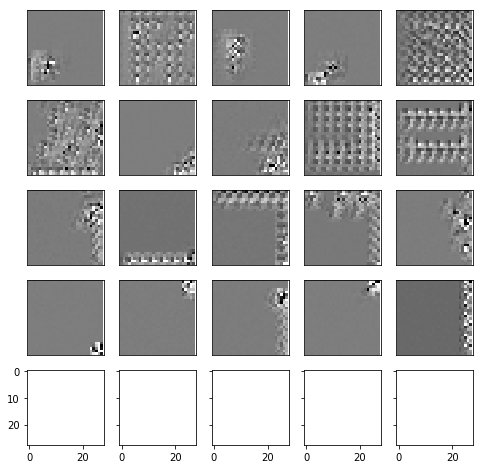

In [454]:
fig, axes = plt.subplots(figsize=(8,8), nrows=5, ncols=5, sharey=True, sharex=True)
for ax, img in zip(axes.flatten(), filters_img_top_images):
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    #_, img_bin = cv2.threshold(img, 175, 255, cv2.THRESH_BINARY) 
    im = ax.imshow(img.reshape((28,28)), cmap='gray')